# Simulation #1
This workbook is a first attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the Perron-Frobenius operator.

In [189]:
using Plots

In [190]:
include("functions.jl");

In [191]:
pyplot();

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [192]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [193]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### An initial density
We will define an initial uniform density $f_0 (x, y)$ on this state space.

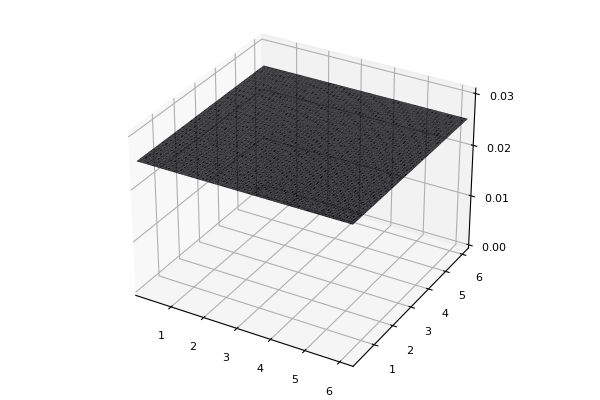

In [194]:
f0s = [f(grid[n,:], range) for n in 1:n_gridpoints];
surface(grid[:,1], grid[:,2], f0s, legend=false, markersize=1)
zlims!(0, 1.2 * (1/(range^2)))

From this initial uniform density $f_0$, we will need to draw a sample.

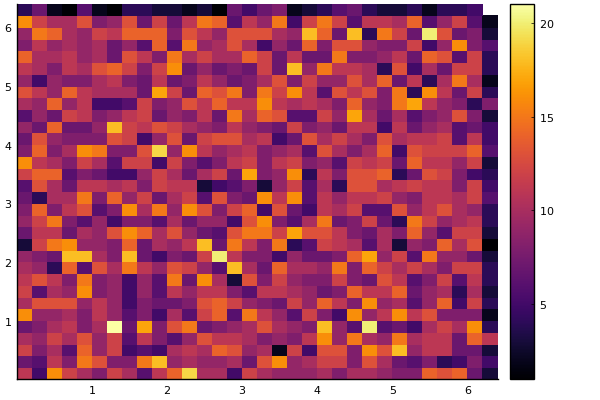

In [195]:
sample_size = 10000;
s = sampledist(sample_size, range);

histogram2d(s[:,1], s[:,2], bins=50)

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the amount of chaos. For the moment we take this to be $a=6$. This map is defined in the function ```S``` which can then be iterated forward across timesteps via ```S_forward```.

We can then easily compare the initial density $f_0$ with a naive estimate of a limiting density $f_*$ by computing the latter with a big value for ```S_forward```.

In [196]:
fstar = S_forward(s, S, 100; map_type="standard");

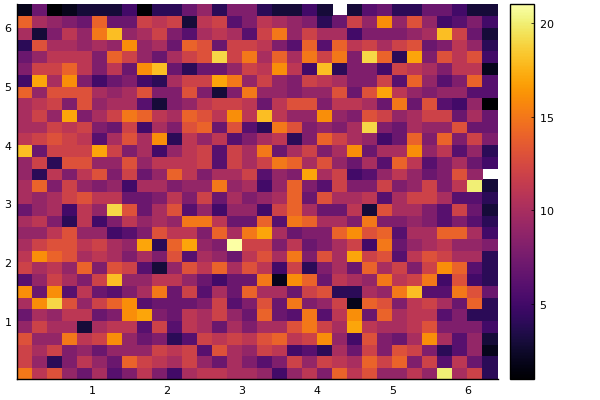

In [197]:
histogram2d(fstar[:,1], fstar[:,2], bins=50)

In this case, the limiting density is precisely the same constant function we started with, so we observe the same uniform distribution for `fstar`.

## Estimating the Perron-Frobenius operator
Having established a model for the dynamics, next we want to estimate the Perron-Frobenius operator,
$$
\mathcal{P} : L^1(X) \to L^1(X) .
$$
In particular, we are interested in this operator in the stochastic setting, which can be characterised by the presence of a transition kernel $k(\cdot, \cdot)$. This can be written as
$$
 \mathcal{P} f(y) = \int_X k(S(x), y ) f(x) \, \mathrm{d}x
$$
where $k(x, y) = \phi(x-y)$. 

To estimate this infinite-dimensional operator, we will need to work in a finite-dimensional subspace of $L^1(X)$, which we call $H$. Since $\mathcal{P}$ is linear, it will then suffice to compute its action on a basis. This will allow us to construct a square matrix $P$, which we will take to be our estimate of $\mathcal{P}$, in that $P(H) = \mathcal{P}(H)$.

### A finite basis
To compute $P$, we first must define a finite basis $H$ for $L^1(X)$. For the moment, we take this basis to be a uniform grid of $B$ Gaussian functions $\left\{ \varphi_i \right\}_{i=1}^B$ defined on the state space $X$. These will be of the form
$$
\varphi_i (x) = \phi ( x - z_i ) := \exp \left( - \frac{\| x - z_i \|^2}{\epsilon^2} \right)
$$
where the $z_i$ denote the centres of each RBF and $\epsilon$ is some bandwidth parameter. Each Gaussian function has integral $c = \int_X \varphi_i (x) \, \mathrm{d}x = \pi \epsilon^2$.

In [198]:
basis_grid_size = 10;
n_bases = basis_grid_size ^ 2;
basis_locs = creategrid(0, range, basis_grid_size);

In [199]:
ϵ = range/basis_grid_size;
c = π * ϵ^2;

These basis functions can be easily visualised by evaluating all grid points against each.

In [200]:
basis_evaluation_matrix = Array{Float64}(undef, n_gridpoints, n_bases);
for b in 1:n_bases
    for n in 1:n_gridpoints
        basis_evaluation_matrix[n, b] = φ(grid[n, :], basis_locs[b, :], ϵ);
    end
end

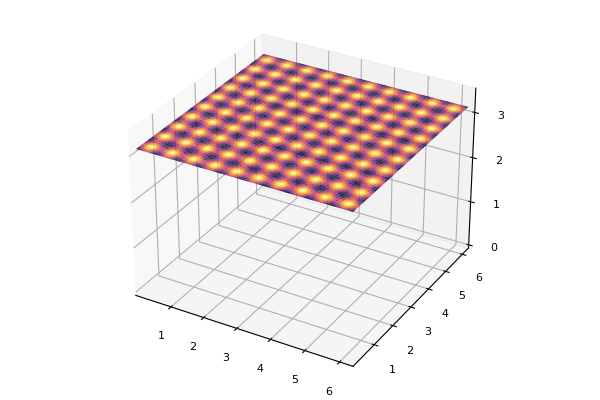

In [201]:
basis_surface = sum(basis_evaluation_matrix, dims=2)[:];
surface(grid[:,1], grid[:,2], basis_surface; legend=false)
zlims!(0,maximum(basis_surface)*1.1)

We get a nice, flat-looking basis surface, which can be used to approximate many functions in $L^1(X)$. To do so, we just take a linear combination of the basis functions. For example:

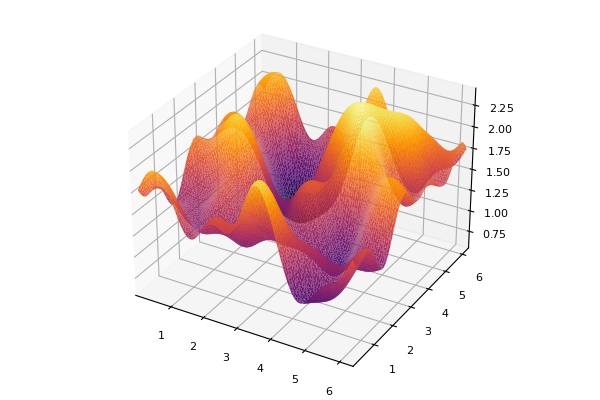

In [202]:
β = rand(n_bases)

test_surface = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], test_surface; legend=false)

Of course, locally this basis surface is not quite so smooth...

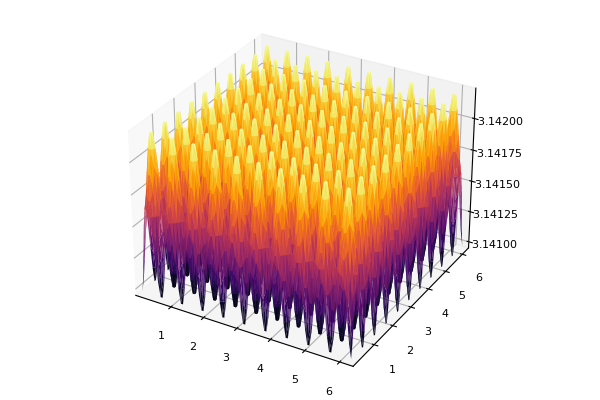

In [203]:
surface(grid[:,1], grid[:,2], basis_surface; legend=false)

...but all the values of the basis surface are nicely packed in a small interval, so this is fine.

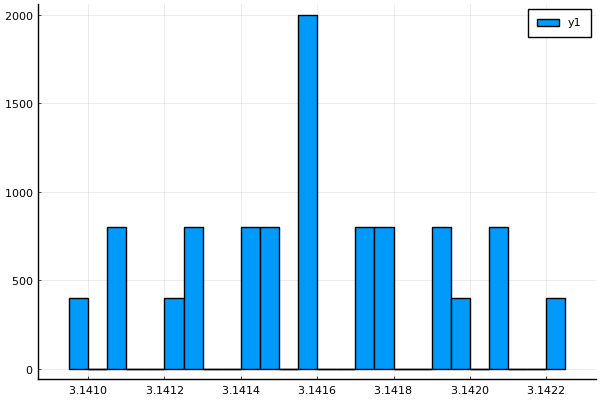

In [204]:
histogram(basis_surface)

### Numerical integration
In order to estimate the integral
$$
    \mathcal{P} f(y) = \int_X k (S(x), y) f(x) \, \mathrm{d}x ,
$$
for some arbitrary function $f\in H$ we will also need an approximate Lebesgue measure for the integral with respect to $\mathrm{d}x$. This will be some weighted combination of all the datapoints (since they are not uniformly spaced), subject to the constraint that obviously each basis function should integrate to $c = \pi\epsilon^2$. We can estimate these weights $w$ using nonnegative least squares,.

In [205]:
Φ = evaluate_phi(s, basis_locs, φ, ϵ);

In [206]:
C = c * ones(n_bases);
w_av = (range^2) / sample_size;

In [207]:
w, residual, objvalue = nnlsq_pen(Φ, C, w_av, 0.01);

Academic license - for non-commercial use only - expires 2021-08-05
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 100 rows, 10100 columns and 884275 nonzeros
Model fingerprint: 0xcac1e6b7
Model has 10100 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-13, 1e+00]
  Objective range  [8e-05, 8e-05]
  QObjective range [2e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.19s
Presolved: 100 rows, 10100 columns, 884275 nonzeros
Presolved model has 10100 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.950e+03
 Factor NZ  : 5.050e+03 (roughly 4 MBytes of memory)
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal  

The weights should sum to close to $(2\pi)^2$, since this is the area of the state space.

In [208]:
println("Total sum of weights: $(sum(w))")
println("Area of state space: $((2π)^2)")
println("Ratio: $(sum(w) / (2π)^2)")

Total sum of weights: 39.47842627523402
Area of state space: 39.47841760435743
Ratio: 1.0000002196358697


We would also expect that the average weight is close to an equal tesselation of the state space, since all the data points are uniformly distributed.

In [209]:
println("Average weight: $(mean(w))")
println("Equal tesselation size: $(w_av)")

Average weight: 0.003947842627523402
Equal tesselation size: 0.0039478417604357436


We might expect that since the sample points are uniformly distributed, the weights would be almost all equal. This is largely true.

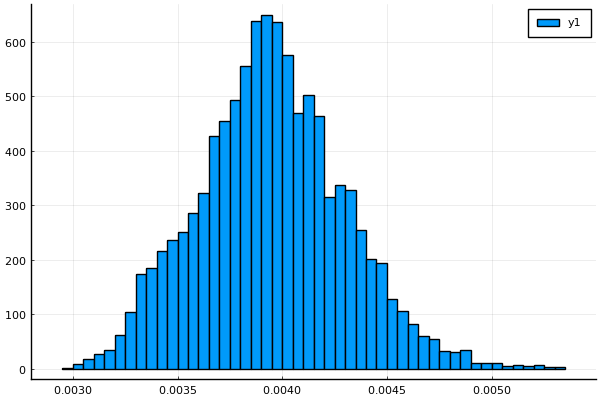

In [210]:
histogram(w)

With these weights, we can now compute the integral $\mathcal{P}f(x)$. In particular, we are interested in computing $\mathcal{P}\varphi_i(x)$ for all $B$ basis functions. Some straightforward arithmetic will show that
\begin{align*}
\mathcal{P}\varphi_i(y) &= \int_X k (Sx, y) \varphi_i(x) \, \mathrm{d}x \\
&= \int_X \phi (Sx - y) \varphi_i(x) \, \mathrm{d}x .
\end{align*}
For convenience, we will use the same stochastic kernel $\phi = \frac{1}{C} \varphi$, where the $\varphi$ are now centered at the image points $S(x) = y$. So the above integral becomes the discrete sum
$$
\mathcal{P}\varphi_i(y) \approx \sum_{n=1}^N \left( w_n \cdot \varphi_i (x_n) \right) \frac{1}{C}\varphi_{y_n} (y)
$$
Hence we can write each of the basis functions $\varphi_i$ as a linear combination of basis functions centered at the image points, $\{ \varphi_{y_n} \}_{n=1}^N$. But we obviously want to be able to write each $\mathcal{P} \varphi_i$ as just a linear combination of the $\varphi_i$. To do this, we will need to 'project' back onto the original subspace $H$ by writing each $\varphi_{y_n}$ itself as a linear combination of the $\varphi_i$.
$$
 \varphi_{y_n} (y) = \sum_{i=1}^B \gamma_i \varphi_i (y)
$$
Where do the weights $\gamma_i$ come from? we will need to calculate them according to a procedure suggested by Ding, Eifler, and Rhee. This says that
$$
\varphi_{y_n} (y) \approx Q \varphi_{y_n} (y) = \sum_{j=1}^B \left( \int_{V_j} c_j \varphi_{y_n} \right) \varphi_j (y) .
$$
Each of these integrals is computed over a Voronoi tesselation of the state space $X$, such that each $V_j$ corresponds to a particular basis function $\varphi_j$. What about the weights $c_i$? These must satisfy
\begin{align*}
    \sum_{i=1}^B \langle \varphi_i , \mathbb{1} \rangle c_i \mathbb{1}_{V_j} &= \mathbb{1} \\
    \sum_{i=1}^B C \cdot c_i \mathbb{1}_{V_j} &= \mathbb{1} \\
    \therefore c_i &= \frac{1}{C}
\end{align*}

In [211]:
X = s;
Y = S(X; map_type="standard");

In [212]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, φ, ϵ);

This is now everything we need to compute the matrix $P$.

In [213]:
P = construct_P(w, Φ, Ξ, c);

In [214]:
display(P)

100×100 Matrix{Float64}:
 0.0298373  0.0174358   0.00464606   …  0.0208968    0.0274484   0.0254289
 0.029632   0.0171205   0.00447987      0.0205874    0.0293467   0.0254783
 0.0290595  0.0172401   0.00528793      0.0174161    0.0285994   0.0244109
 0.0305895  0.0178048   0.0061421       0.0176546    0.0350375   0.0293976
 0.0318121  0.0156868   0.00513354      0.0159667    0.036203    0.0322206
 0.0341221  0.0151966   0.00449845   …  0.0122534    0.033295    0.0342498
 0.0319015  0.0156451   0.00488751      0.0102996    0.0300353   0.0336372
 0.0295728  0.015147    0.00473559      0.0108269    0.0262323   0.0327484
 0.0297594  0.0159431   0.00458991      0.0141026    0.0246651   0.0324947
 0.0291009  0.0164125   0.00458624      0.0175756    0.0244913   0.0276071
 0.0153917  0.00374486  0.000780897  …  0.0437484    0.0469463   0.0186875
 0.0198146  0.00431625  0.000680268     0.0303826    0.0404833   0.0201138
 0.0241963  0.00532847  0.000717723     0.0178811    0.03032     0.0199802


## Checking the results
Now that we have an estimate of $P$, we can start appraising it.

### Plotting the spectrum
We expect that $P$ should have a leading unit eigenvalue, and all the remaining eigenvalues should have modulus less than one.

In [215]:
λ, Λ = ordered_eigendecomp(P);

In [216]:
display(λ[1])

0.99999991824129 + 0.0im

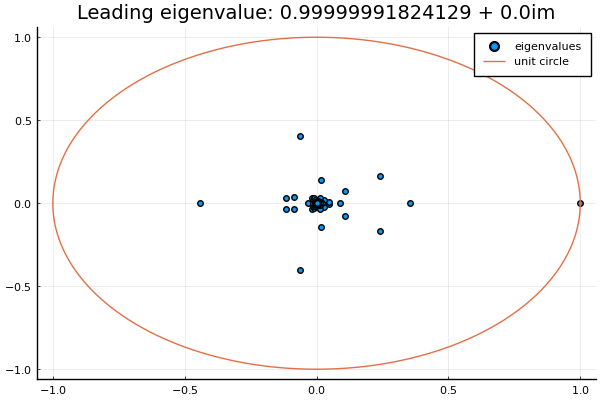

In [234]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")
title!("Leading eigenvalue: $(λ[1])")

Happily, this does indeed appear to be the case.

### Row stochasticity
We also expect that the estimate should be row-stochastic.

In [237]:
row_sums = sum(P, dims=2)[:];
col_sums = sum(P, dims=1)[:];

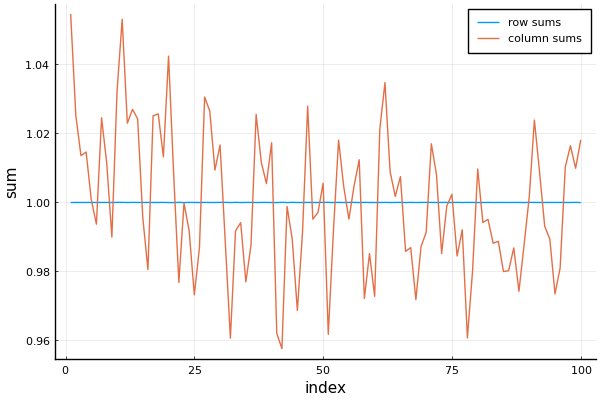

In [243]:
plot(row_sums, label="row sums")
plot!(col_sums, label="column sums")
xlabel!("index")
ylabel!("sum")

Row sums are indeed constant; this value is of course the leading unit eigenvalue.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density.

In [220]:
α = real.(Λ[:,1]);

In [221]:
display(α)

100-element Vector{Float64}:
 -0.0999976491037168
 -0.10000126716352063
 -0.09999935478637025
 -0.099999777192432
 -0.10000003266211666
 -0.09999959987163147
 -0.10000059729060118
 -0.1000003514028347
 -0.0999979861971954
 -0.10000271705336218
 -0.10000276232957228
 -0.09999823998468013
 -0.10000159976099257
  ⋮
 -0.09999774707477768
 -0.10000228046171744
 -0.10000120241326382
 -0.09999962384642433
 -0.09999988649328298
 -0.10000032314802004
 -0.0999997186245402
 -0.10000056380839548
 -0.09999976676878737
 -0.09999886838832318
 -0.1000027235346821
 -0.09999745703816891

In [222]:
invariant_density = basis_combination(grid, basis_locs, φ, ϵ, α);

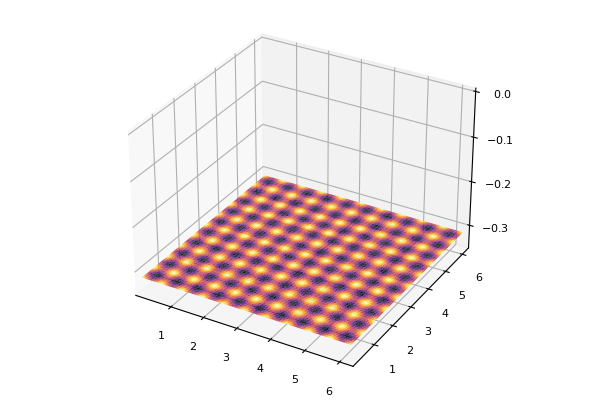

In [223]:
surface(grid[:,1], grid[:,2], invariant_density; legend=false)

if mean(invariant_density) > 0
    zlims!(0, maximum(invariant_density)*1.1)
else
    zlims!(minimum(invariant_density)*1.1, 0)
end

This looks pretty flat, which is good, since we know that the invariant density under the standard map is just the constant function.

### Integral preservation and evolving forward a density
Last, we try directly evolving forward a density using $P$, and use this as an occasion to check that indeed preserves integrals. We start with a random function $f \in H$, where $f = \sum_{i=1}^B \beta_i \varphi_i$.

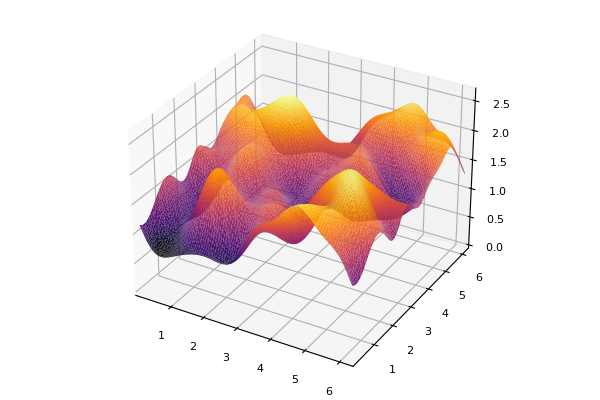

In [224]:
β = rand(n_bases)

initial_density = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], initial_density; legend=false)
zlims!(0, maximum(initial_density)*1.1)

In [225]:
integral = sum(initial_density)/n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.5883672530274908


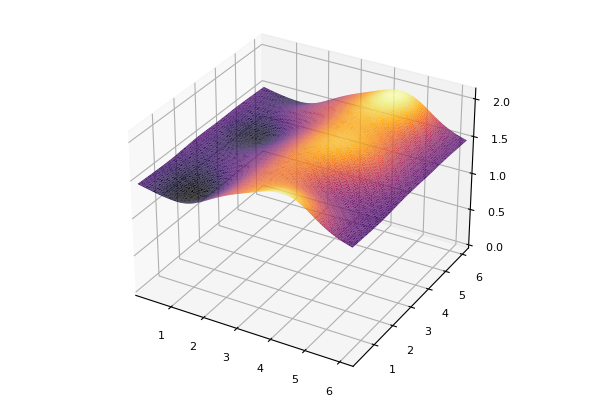

In [226]:
β1 = P * β;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β1);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

In [227]:
integral = sum(evolved_density)/n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.5863054994607952


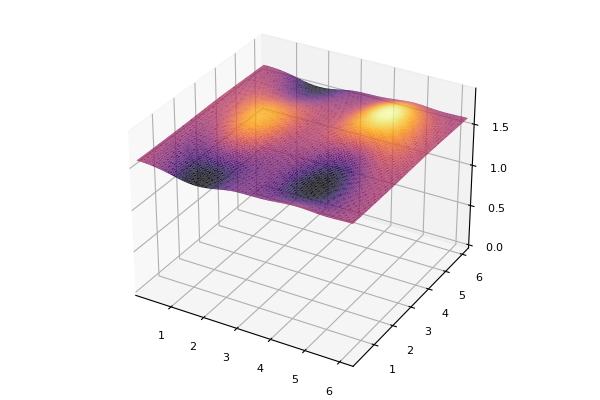

In [228]:
β2 = P * β1;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β2);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

In [229]:
integral = sum(evolved_density)/n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.5851823937234029


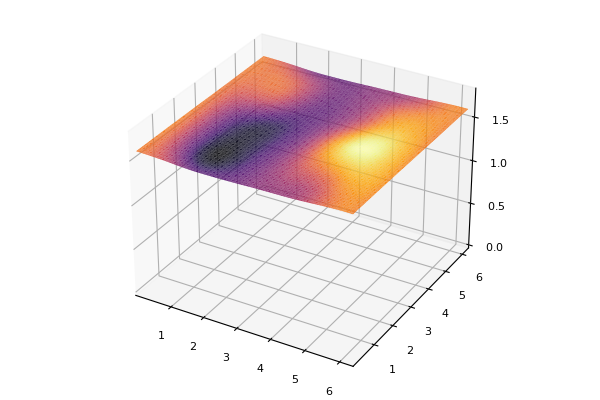

In [230]:
β3 = P * β2;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β3);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
zlims!(0, maximum(evolved_density)*1.1)

In [231]:
integral = sum(evolved_density)/n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.584884300919594


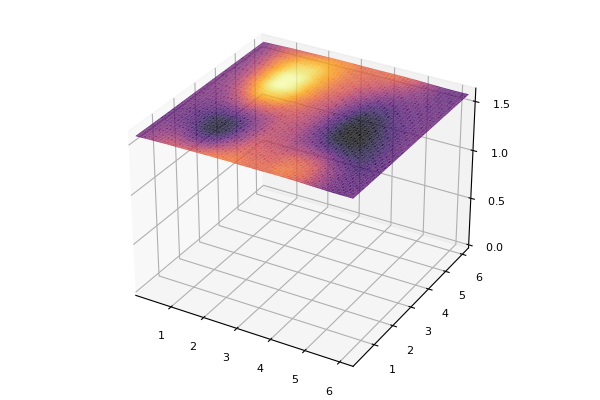

In [244]:
β4 = P * β3;

evolved_density = basis_combination(grid, basis_locs, φ, ϵ, β4);
surface(grid[:,1], grid[:,2], evolved_density; legend=false)
#zlims!(0, maximum(evolved_density)*1.1)

In [233]:
integral = sum(evolved_density)/n_gridpoints;
println("Estimate of integral: $integral")

Estimate of integral: 1.5849456662250294


After just three applications of $P$, we already see the limiting density start to emerge. Also, integrals are approximately preserved across each application.

## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.